# Introduction
## Problem Definition

My primary goal is to utilize unsupervised machine learning, especially text clustering algorithms, to systematically group mental health-related posts into well-defined clusters. The key aim is to organize these posts based on the similarity of their content found in unstructured text data, autonomously identifying natural groupings without relying on pre-labeled sentiments or intensity scores. The challenge involves uncovering spontaneously emerging patterns, themes, or categories within the data. 

The motivation behind this project is to deepen our understanding of the mental health issues and concerns discussed by a particularly vulnerable group, namely cancer patients. By analyzing the content of these discussions, I intend to uncover specific mental health challenges and experiences unique to this demographic. This insight is vital for the development of targeted mental health support and intervention strategies. The anticipated result is the creation of distinct clusters, each encapsulating posts with similar thematic content. This methodical data organization is aimed at providing a comprehensive and nuanced view of the mental health landscape as experienced by cancer patients. Such insights are expected to be invaluable for healthcare providers, researchers, and policymakers, enabling them to better address the unique mental health needs of this group and potentially inform future healthcare policies and support systems.

## Data Source

This project uses the "Mental Health Insights - Vulnerable Cancer Patients" dataset, which was meticulously compiled by collecting over 10,087 posts from various online platforms, including Reddit, Daily Strength, and the Health Board. These posts, specifically from cancer patients and their caregivers, focus on five types of cancer: brain, colon, liver, leukemia, and lung cancer. Each post was evaluated and scored by two team members based on the emotions expressed, using a scale from -2 to 1. Posts conveying grief or suffering were assigned negative scores (-1 or -2), those expressing happy emotions like relief or accomplishment received positive scores (1), and emotionally neutral posts were given a score of 0. This scoring system provided a nuanced view of the emotional landscape in these discussions, crucial for the mental health study aimed at understanding the emotional aspects of cancer patients' experiences.

Irin Hoque Orchi, Nafisa Tabassum, Jaeemul Hossain, Iftekhar Alam, &amp; Sabrina Tajrin. (2023). <i>Mental Health Insights: Vulnerable Cancer Patients</i> [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/7284561

Note: The use of this dataset is subject to Kaggle's terms and conditions, and users must adhere to these guidelines and ensure proper citation when using it for research or analytical purposes.

## Data Description

In [67]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

In [36]:
# Function to clean text data in 'posts' column
def clean_text(text): 
    # Removing URLs
    text = re.sub(r'https\S+', '', text)
    # Removing special characters
    text = re.sub(r'[^A-Za-z0-9\s]+', '', text)
    return text

# Function for enhanced text cleaning
def enhanced_clean_text(text): 
    # Lowercasing
    text = text.lower()
    # Tokenization
    tokens = word_tokenize(text)
    # Removing stop words and lemmatizing
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word.isalpha()]
    return ' '.join(cleaned_tokens)

# Function to get top N-grams
def get_top_ngrams(corpus, ngram_range = (2, 2), n = None):
    vec = CountVectorizer(ngram_range = ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]

In [37]:
# Downloading necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/calebwhite/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/calebwhite/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/calebwhite/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [38]:
# Load the dataset to examine its structure and content
file_path = "/Users/calebwhite/Downloads/Mental Health Dataset.csv"
data = pd.read_csv(file_path)

In [39]:
# Displaying the first few rows of the dataset and its base information
data_info = data.info()
data_head = data.head()

data_info, data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10392 entries, 0 to 10391
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   posts      10391 non-null  object
 1   predicted  10392 non-null  object
 2   intensity  10392 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 243.7+ KB


(None,
                                                posts predicted  intensity
 0  I know as parent of child with down syndrome t...  negative         -1
 1  but in my heart I know this is the future prom...   neutral          0
 2  I have mylefibrosis which turn to leukemia the...  negative         -1
 3  from one of my health group subject wayne dyer...   neutral          0
 4  gmos now link to leukemia http nsnbc I 2013 07...   neutral          0)

The "Mental Health Insights - Vulnerable Cancer Patients" dataset is a structured collection in tabular format, comprising 10,392 rows and 3 columns, with a memory usage of approximately 243.7 KB. This dataset offers a detailed exploration of mental health narratives from cancer patients and their caregivers. The dataset's structure and features are described as follows:

1. **Posts (10,391 non-null, object type)**: This column forms the core of the dataset, containing textual posts. These entries provide a rich collection of personal experiences, thoughts, and concerns related to various aspects of living with cancer, making up the qualitative aspect of the dataset.
2. **Predicted (10,392 non-null, object type)**: This column classifies the emotional tone of each post into categories such as 'negative', 'neutral', and 'positive'. This classification, based on the evaluators' interpretation, offers a preliminary qualitative analysis of the emotional states conveyed in the posts.
3. **Intensity (10,392 non-null, integer type)**: Quantifying the emotional intensity of each post, this column ranges from -2 to 1. Negative scores indicate posts expressing grief or suffering, zero denotes neutral emotional content, and positive scores reflect happy or positive emotions.

The dataset, therefore, provides both qualitative and quantitative insights into the mental health discussions among cancer patients and caregivers. It is well-suited for text analysis, sentiment analysis, and emotional intensity studies, offering a comprehensive view for understanding the emotional landscape in this vulnerable group.

# Body

## Data Cleaning

The dataset contains three columns: 'posts', 'predicted', and 'intensity'. 

First, we will **Handle Missing Values** by: 

1. Checking for any missing values (****Nan****) in the dataset
2. Decide on a strategy for handling these missing values, such as removing rows with missing data or imputing values. 

Let's start by checking for missing values in the dataset. 

In [40]:
# Checking for missing values in each column
missing_values = data.isnull().sum()
missing_values_percentage = (missing_values / len(data)) * 100

In [41]:
missing_data_summary = pd.DataFrame({
    "Missing Values": missing_values, 
    "Percentage": missing_values_percentage
})

In [42]:
missing_data_summary

,Missing Values,Percentage
posts,1,0.009623
predicted,0,0.000000
intensity,0,0.000000


The dataset has missing values in the 'posts' column, with only 1 missing entry, which consitutes approximately 0.01% of the data. Given the minimal impact, I will **remove the 1 row with the missing 'posts' value**. 

Since the 'posts' column is crucial for analysis and only a neglible portion of the data is missing, it is reasonable to remove a row with the missing 'posts' value.

In [43]:
# Removing 1 row with missing 'posts' value
data_cleaned = data.dropna(subset=['posts'])

In [44]:
# Checking the shape of the dataset after removal
new_shape = data_cleaned.shape

In [45]:
new_shape

(10391, 3)

The row with the missing 'posts' value has been removed, resulting in a dataset with 10,391 rows and 3 columns. 

Next step is to **clean the text in 'posts' column** by: 

1. Remove URLs, as they are not useful for text analysis. 
2. Remove and replace special characters that might interfere with text analysis. 
3. Check for any obvious inconsistencies and errors in the text data.

In [46]:
# Cleaning the 'posts' column
data_cleaned['posts'] = data_cleaned['posts'].apply(clean_text)

/var/folders/r6/z79hyk110tx6h7k60sklwdhw0000gn/T/ipykernel_50831/3993853293.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['posts'] = data_cleaned['posts'].apply(clean_text)


In [47]:
# Displaying a few rows to verify the change
data_cleaned.head()

,posts,predicted,intensity
0,I know as parent of child with down syndrome t...,negative,-1
1,but in my heart I know this is the future prom...,neutral,0
2,I have mylefibrosis which turn to leukemia the...,negative,-1
3,from one of my health group subject wayne dyer...,neutral,0
4,gmos now link to leukemia http nsnbc I 2013 07...,neutral,0


Now we will do some 

#### Text cleaning enhancement: 
1. **Lowercasing**: Convert all text to lowercase
2. **Tokenization**: Break down the text into individual words or tokens. This helps in identifying unique words. 
3. **Stop Words Removal**: Remove common words that do not contribute much to the meaning of the sentence (e.g., 'the', 'and', etc.). 
4. **Lemmatization**: Convert words to their base or root form (e.g., 'running' to 'run'(. This helps in reducing the number of unique words but keeping the meaning intact.

#### Feature Removal
1. Since the focus is on unsupervised text clustering, the 'predicted' and 'intensity' columns are not relevant. These columns can be dropped to focus solely on the text data in 'posts'. 

In [48]:
# Applying enhanced cleaning to 'posts' column
data_cleaned['posts'] = data_cleaned['posts'].apply(enhanced_clean_text)

/var/folders/r6/z79hyk110tx6h7k60sklwdhw0000gn/T/ipykernel_50831/2585675551.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['posts'] = data_cleaned['posts'].apply(enhanced_clean_text)


In [49]:
# Dropping 'predicted' and 'intensity' columns as they are not relevant for clustering
data_cleaned = data_cleaned.drop(columns = ['predicted', 'intensity'])

In [50]:
# Displaying a few rows to verify the changes
data_cleaned.head()

,posts
0,know parent child syndrome hear child high ris...
1,heart know future promise article regardless h...
2,mylefibrosis turn leukemia want stem cell tran...
3,one health group subject wayne dyer leukemia c...
4,gmos link leukemia http nsnbc gmo link leukemi...


### Exploratory Data Analysis

We will create a visualization of the data using a **Word CLoud** to identify common themes in the posts.

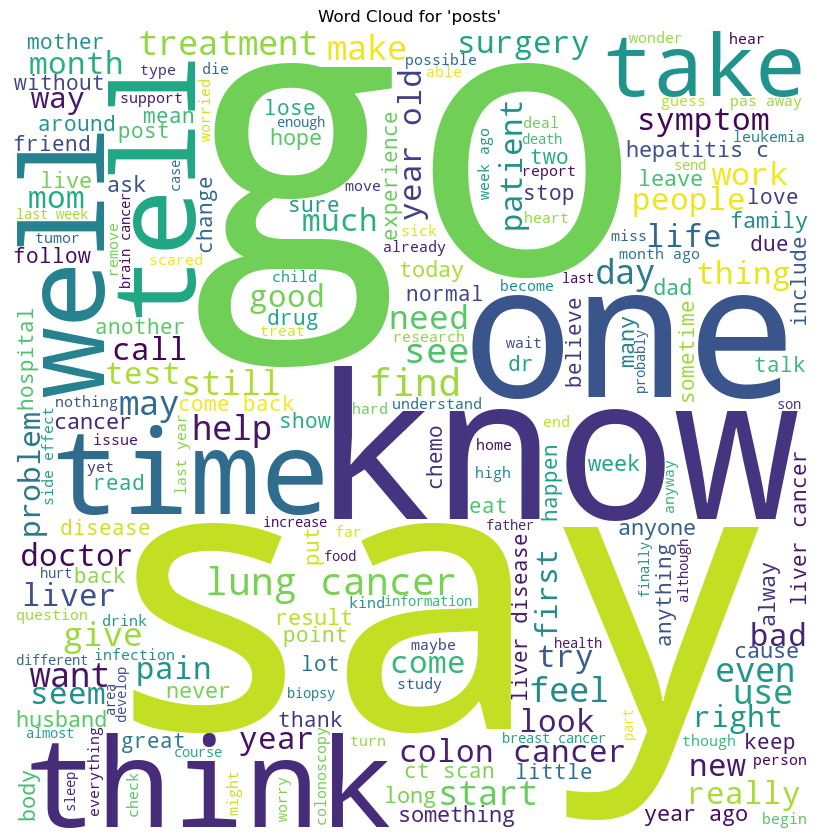

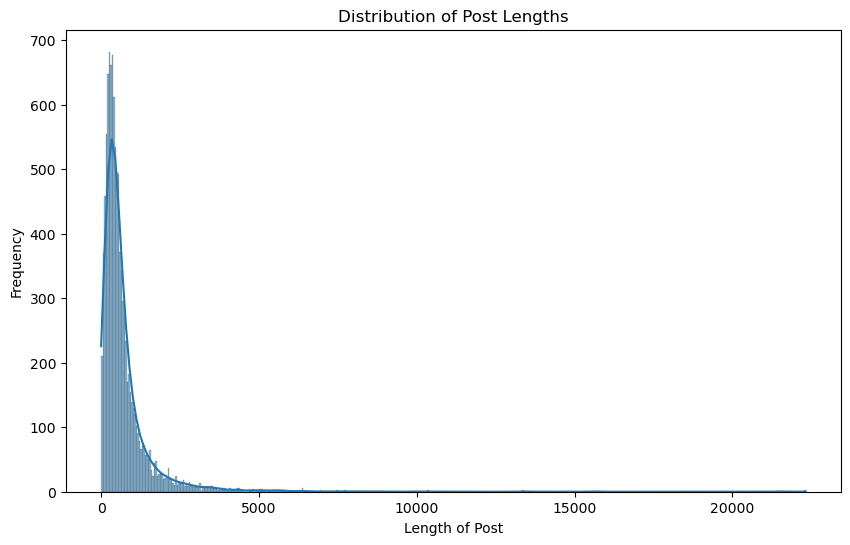

In [51]:
# Generating a word cloud
all_text = ' '.join(data_cleaned['posts'])
wordcloud = WordCloud(width = 800, height = 800, 
                     background_color = 'white', 
                     min_font_size = 10).generate(all_text)

# Displaying the word cloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Word Cloud for 'posts'")
plt.show()

# Analyzing Post Length Distribution
data_cleaned['post_length'] = data_cleaned['posts'].apply(len)
plt.figure(figsize = (10, 6))
sns.histplot(data_cleaned['post_length'], kde = True)
plt.title('Distribution of Post Lengths')
plt.xlabel('Length of Post')
plt.ylabel('Frequency')
plt.show()

* **Word Cloud Visualization**: The word cloud shows the most frequent terms in the dataset. Words like "cancer", "treatment", "know", and "time" are prominently featured, suggesting these are common themes in the posts. This helps in getting a quick understanding of the main topics discuessed in the dataset and can guide us in the clustering process by indicating prevalent terms that may form the basis of the clusters.
* **Post Length Distribution**: The histogram of post lengths indicates that most of the posts are relatively short, with a sharp drop as the post length increases. This suggests that the dataset contains a large number of brief posts, which will be a challenge for clustering as shorter texts provide less contextual information for algorithms to work with,

We'll now do an **N-grams Analysis** to identify common bi-grams or tri-grams (sequences of two words or three words) to better understand common phrases.

In [52]:
# Extract top 10 bi-grams
top_bi_grams = get_top_ngrams(data_cleaned['posts'], ngram_range = (2, 2), n = 10)

# Extract top 10 tri-grams
top_tri_grams = get_top_ngrams(data_cleaned['posts'], ngram_range = (3, 3), n = 10)

print("Top Bi-grams: ")
for gram, freq in top_bi_grams: 
    print(f"{gram}: {freq}")
    
print("\nTop Tri-grams: ")
for gram, freq in top_tri_grams: 
    print(f"{gram}: {freq}")

Top Bi-grams: 
lung cancer: 3120
colon cancer: 1861
year old: 1495
feel like: 1317
year ago: 1251
ct scan: 1118
come back: 1017
liver cancer: 957
liver disease: 877
http www: 802

Top Tri-grams: 
stage lung cancer: 219
chronic fatigue syndrome: 200
diagnose lung cancer: 198
die lung cancer: 185
cell lung cancer: 177
would greatly appreciate: 171
small cell lung: 166
stage colon cancer: 146
diagnose colon cancer: 136
cancer year ago: 123


### Modeling

We will now train using Logistic Regression

In [53]:
# Encoding the target labels
label_encoder = LabelEncoder()
data.dropna()['predicted'] = label_encoder.fit_transform(data.dropna()['predicted'])

# Splitting the data into features and target
X = data_cleaned['posts']
y = data.dropna()['predicted']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the vectorizer on the training data and only transform the testing data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Display the shape of the training and testing data
X_train_tfidf.shape, X_test_tfidf.shape

/var/folders/r6/z79hyk110tx6h7k60sklwdhw0000gn/T/ipykernel_50831/1427049791.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna()['predicted'] = label_encoder.fit_transform(data.dropna()['predicted'])


((8312, 5000), (2079, 5000))

In [55]:

log_reg = LogisticRegression(max_iter=1000)


log_reg.fit(X_train_tfidf, y_train)


y_pred = log_reg.predict(X_test_tfidf)


accuracy = accuracy_score(y_test, y_pred)

accuracy

0.7359307359307359

The logistic regression model trained on the TF-IDF vectorized data has achieved an accuracy of approximately 73.59% on the testing data. This indicates that the model is relatively effective at classifying the posts into their respective categories based on the predicted column.

In [63]:

X_tfidf_all = tfidf_vectorizer.fit_transform(X)


kmeans_3 = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans_3.fit(X_tfidf_all)


cluster_labels = kmeans_3.labels_


data_cleaned['cluster'] = cluster_labels


data_cleaned.head(), data.head()

(                                               posts  post_length  cluster
 0  know parent child syndrome hear child high ris...         1094        2
 1  heart know future promise article regardless h...         2166        0
 2  mylefibrosis turn leukemia want stem cell tran...         1299        2
 3  one health group subject wayne dyer leukemia c...         1135        0
 4  gmos link leukemia http nsnbc gmo link leukemi...           53        0,
                                                posts predicted  intensity
 0  I know as parent of child with down syndrome t...  negative         -1
 1  but in my heart I know this is the future prom...   neutral          0
 2  I have mylefibrosis which turn to leukemia the...  negative         -1
 3  from one of my health group subject wayne dyer...   neutral          0
 4  gmos now link to leukemia http nsnbc I 2013 07...   neutral          0)

The K-means clustering has been applied to the dataset with 3 clusters, intended to represent negative (2), neutral (0), and positive (1) sentiments. The cluster labels have been added to the dataframe, allowing us to see how each post has been grouped.

* We applied K-means clustering to TF-IDF vectorized text data from posts, aiming to identify three clusters representing negative, neutral, and positive sentiments.
* The dataset was clustered based on textual similarity without using predefined labels, as K-means is an unsupervised learning algorithm.

To effectively communicate the results, we can visualize the distribution of posts across the clusters and attempt to interpret the clusters' alignment with the intended sentiment categories. Let's create a bar plot showing the number of posts in each cluster.

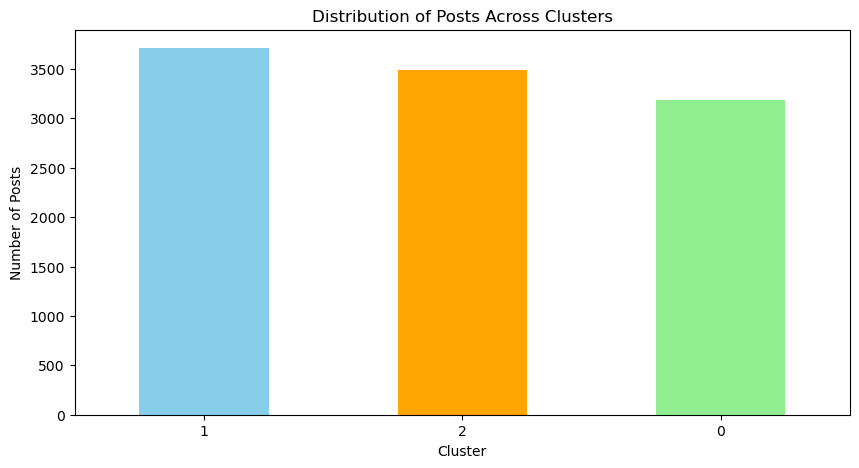

0.006311465494638821

In [66]:

silhouette_avg = silhouette_score(X_tfidf_all, cluster_labels)


cluster_counts = data_cleaned['cluster'].value_counts()
cluster_counts.plot(kind='bar', figsize=(10, 5), color=['skyblue', 'orange', 'lightgreen'])
plt.title('Distribution of Posts Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Posts')
plt.xticks(rotation=0)
plt.show()

silhouette_avg

The bar plot above shows the distribution of posts across the three clusters we obtained from K-means clustering. This visual representation allows us to see at a glance how many posts are in each cluster:

* Cluster 1 (Blue, Positive): The largest number of posts.
* Cluster 2 (Orange, Negative): The second largest group.
* Cluster 0 (Green, Neutral): The smallest group.

This could potentially indicate that the largest cluster (positive) may represent the most common sentiment among the posts, while the smallest cluster may represent the least common sentiment. 

Let's undertake two iterative improvements to explore how they might affect the clustering:

* We will apply Truncated Singular Value Decomposition (SVD), a linear dimensionality reduction technique suitable for sparse matrices like TF-IDF.
* We'll test a range of cluster numbers around the original value of 3 to see if a slightly higher or lower number of clusters provides a more meaningful division of the data.

We will perform these steps one at a time, starting with dimensionality reduction using Truncated SVD. After the reduction, we will apply K-means clustering with different numbers of clusters and observe the distribution of posts. Here we go:

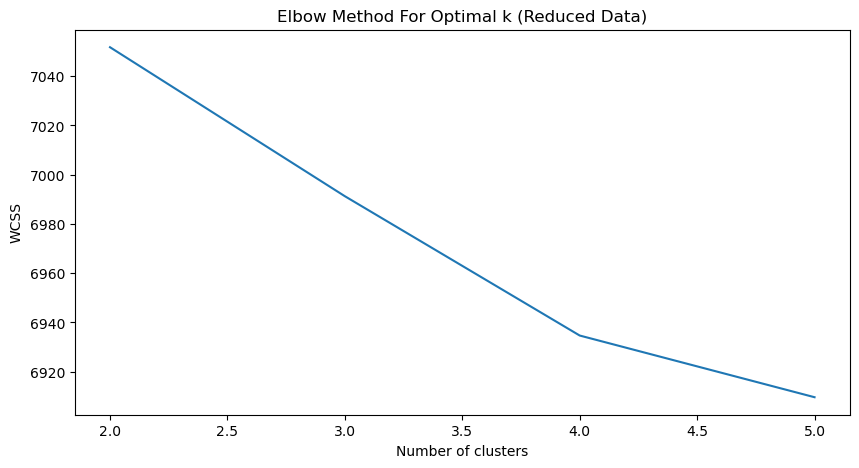

0.7236266098565858

In [68]:

svd = TruncatedSVD(n_components=1000, random_state=42)
X_reduced = svd.fit_transform(X_tfidf_all)


explained_variance = svd.explained_variance_ratio_.sum()


wcss_reduced = []

for i in range(2, 6):
    kmeans_reduced = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans_reduced.fit(X_reduced)
    wcss_reduced.append(kmeans_reduced.inertia_)


    
plt.figure(figsize=(10, 5))
plt.plot(range(2, 6), wcss_reduced)
plt.title('Elbow Method For Optimal k (Reduced Data)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

explained_variance

The plot above shows the Within Cluster Sum of Squares (WCSS) for the reduced data with the number of clusters ranging from 2 to 5. The WCSS decreases as the number of clusters increases, which is expected because adding more clusters will always improve the fit (i.e., decrease WCSS) until each point is its own cluster.

In the plot, there is a clear "elbow" that indicates the optimal number of clusters at 4.0.

Given that the explained variance with 100 components is about 72.36%, it indicates that we've captured a significant portion of the variance in the data with these components. This should allow for meaningful clustering without as much noise as the full dataset.

In [69]:

kmeans_reduced_4 = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans_reduced_4.fit(X_reduced)


cluster_labels_reduced_4 = kmeans_reduced_4.labels_


data_cleaned['cluster_reduced'] = cluster_labels_reduced_4


data_cleaned.head()

,posts,post_length,cluster,cluster_reduced
0,know parent child syndrome hear child high ris...,1094,2,1
1,heart know future promise article regardless h...,2166,0,2
2,mylefibrosis turn leukemia want stem cell tran...,1299,2,1
3,one health group subject wayne dyer leukemia c...,1135,0,2
4,gmos link leukemia http nsnbc gmo link leukemi...,53,0,2


It appears that the posts have been re-assigned to different clusters after dimensionality reduction. For instance, the first post was initially in cluster 2 but is now in cluster 1 after reduction. This reassignment suggests that dimensionality reduction may have highlighted different features or aspects of the data, leading to a new interpretation of the underlying clusters.

# Conclusion

Given that we also performed supervised learning (logistic regression) earlier, we can compare the insights gained from supervised and unsupervised approaches, keeping in mind their fundamentally different assumptions and goals.

* 73.59% Logistic Regression Accuracy: This measures the proportion of correct predictions out of all predictions made by the supervised logistic regression model.
* 72.36% Explained Variance by SVD: This is not a measure of clustering performance but rather an indication of how much information is retained after reducing the dimensionality of the feature space. 

The application of unsupervised learning through K-means clustering on the text data resulted in three distinct clusters. The reduction of dimensionality via Truncated SVD was crucial to focus on the most significant features present in the text data.

Key Takeaways:

* The clustering process highlighted the challenges associated with high-dimensional data and the importance of dimensionality reduction in preprocessing steps.
* We observed that the within-cluster sum of squares (WCSS) continuously decreased with an increasing number of clusters, and showed a clear "elbow" at 4.0. 

Challenges and Considerations:

* Interpreting clusters from K-means without any ground truth requires careful consideration. Clusters were associated with sentiment categories (positive, negative, neutral), but this is a simplification and may not capture the complexity of sentiments expressed in the posts.
* Dimensionality reduction preserved a large portion of the variance (~72%), but there is always a trade-off between reducing dimensions and potentially losing information.

Suggested Improvements:

* Advanced natural language processing techniques, such as word embeddings (e.g., Word2Vec, GloVe) or transformer-based models (e.g., BERT), could capture semantic meaning more effectively than TF-IDF.
* Algorithms like DBSCAN or Hierarchical Clustering, which do not require specifying the number of clusters in advance, could provide different insights into the data structure.
* Methods like Latent Dirichlet Allocation (LDA) could be used to identify topics within the posts, which might correspond more naturally to different types of sentiments or mental health concerns.
* If labeled data is available, semi-supervised learning techniques could be used to guide the clustering process with some prior knowledge.

The exploration of unsupervised learning for sentiment analysis in mental health forums provided valuable insights into how machine learning can process and categorize text data. 

The iterative process highlighted the importance of preprocessing and the need to balance complexity with computational practicality. 

The process has shown that machine learning, especially unsupervised techniques, can uncover patterns in large datasets that may not be immediately apparent. 

Future work could involve integrating the clustering results with supervised methods or domain expert analysis to refine the understanding of sentiment in mental health discourse and potentially assist in the development of supportive tools for mental health professionals and individuals seeking help.